## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import tools_ar
from variaIa import baserate
from importlib import reload
from variaIa import stretchevol
from scipy.stats import poisson
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full, z_max
from scipy.ndimage.filters import uniform_filter1d
from IPython.display import display, Latex
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "EB Garamond",
})
    # "axes.labelsize": 'x-large',
    # "xtick.labelsize": 'x-large',
    # "ytick.labelsize": 'x-large'})
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools_ar.cons, su=tools_ar.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
surveysnl = surveys[0:1]+surveys[2:]

## Utilisation de la classe _stretchevol_ pour le fit double total

In [3]:
evol3G2M2S = stretchevol.Evol3G2M2S(df_nc)

#evol3G2M2S.GUESSVAL[3] = -1

evol3G2M2S.minimize()

print(evol3G2M2S.migrad_out.errors)

###################################################

evol3G2M2S_cons = stretchevol.Evol3G2M2S(df_c)

#evol3G2M2S_cons.GUESSVAL[3] = -1

evol3G2M2S_cons.minimize()

#evol3G2M2S_cons.migrad_out[1]

#evol3G2M2S.plotter()

#fig=plt.gcf()
#fig.savefig('/home/nora/Pictures/BiGaussian.pdf')

<ErrorView aa=0.23181914689103936 mu_1=0.03796254033295066 sigma_1=0.025420654080614554 mu_2=0.11400034713662424 sigma_2=0.06752723930943813>


## Test without SNf Data

In [5]:
evol3G2M2S_nsnf = stretchevol.Evol3G2M2S()
evol3G2M2S_nsnf.set_data(df[df['survey'].isin(['SDSS','PS1','SNLS','HST'])])

evol3G2M2S_nsnf.minimize()

## Get _a_ and _a-err_

In [4]:
aa_list = scipy.stats.norm.rvs(loc=evol3G2M2S.migrad_out.values[0],
                               scale=evol3G2M2S.migrad_out.errors[0],
                               size=10000)
a_list = evol3G2M2S.get_a(aa_list)
vmin, vc, vmax = np.percentile(a_list, [16, 50, 84])

print('vmin =', round(vmin, 3))
print('vc =', round(vc, 3))
print('vmax =', round(vmax, 3))
print('a =', round(vc, 3), '^', round(vmax-vc, 2), '_', round(-(vc-vmin), 2))

aa_list = scipy.stats.norm.rvs(loc=evol3G2M2S_cons.migrad_out.values[0],
                               scale=evol3G2M2S_cons.migrad_out.errors[0],
                               size=10000)
a_list = evol3G2M2S_cons.get_a(aa_list)
vmin, vc, vmax = np.percentile(a_list, [16, 50, 84])

print('vmin =', round(vmin, 3))
print('vc =', round(vc, 3))
print('vmax =', round(vmax, 3))
print('a =', round(vc, 2), '^', round(vmax-vc, 2), '_', round(-(vc-vmin), 2))

vmin = 0.431
vc = 0.502
vmax = 0.574
a = 0.502 ^ 0.07 _ -0.07
vmin = 0.406
vc = 0.466
vmax = 0.53
a = 0.47 ^ 0.06 _ -0.06


In [42]:
print({p: round(evol3G2M2S.param[p], 2) for p in evol3G2M2S.param.keys()})
print({f'{p}_err': round(evol3G2M2S.m_tot.errors[p], 2) for p in evol3G2M2S.param.keys()})

{'aa': 0.01, 'mu_1': 0.37, 'sigma_1': 0.61, 'mu_2': -1.22, 'sigma_2': 0.56}
{'aa_err': 0.23, 'mu_1_err': 0.04, 'sigma_1_err': 0.03, 'mu_2_err': 0.11, 'sigma_2_err': 0.07}


In [43]:
print({p: round(evol3G2M2S_cons.param[p], 2) for p in evol3G2M2S_cons.param.keys()})
print({f'{p}_err': round(evol3G2M2S_cons.m_tot.errors[p], 2) for p in evol3G2M2S_cons.param.keys()})

{'aa': -0.11, 'mu_1': 0.38, 'sigma_1': 0.6, 'mu_2': -1.26, 'sigma_2': 0.53}
{'aa_err': 0.2, 'mu_1_err': 0.04, 'sigma_1_err': 0.03, 'mu_2_err': 0.09, 'sigma_2_err': 0.06}


## Utilisation de la classe _stretchevol_ pour le fit double

In [4]:
reload(stretchevol)

evolSNF = stretchevol.Evol3G2M2S(df)

evolSNF.minimize()

#fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/BiGaussian.pdf', bbox_inches='tight')

In [22]:
aa_list = scipy.stats.norm.rvs(loc=evolSNF.migrad_out.values[0],
                               scale=evolSNF.migrad_out.errors[0],
                               size=10000)
a_list = evolSNF.get_a(aa_list)
vmin, vc, vmax = np.percentile(a_list, [16, 50, 84])

print('vmin =', round(vmin, 3))
print('vc =', round(vc, 3))
print('vmax =', round(vmax, 3))
print('a =', round(vc, 2), '^', round(vmax-vc, 2), '_', round(-(vc-vmin), 2))

vmin = 0.425
vc = 0.482
vmax = 0.54
a = 0.48 ^ 0.06 _ -0.06


In [45]:
print({p: round(evolSNF.param[p], 2) for p in evolSNF.param.keys()})
print({f'{p}_err': round(evolSNF.m_tot.errors[p], 2) for p in evolSNF.param.keys()})

{'aa': -0.06, 'mu_1': 0.41, 'sigma_1': 0.55, 'mu_2': -1.38, 'sigma_2': 0.44}
{'aa_err': 0.18, 'mu_1_err': 0.05, 'sigma_1_err': 0.04, 'mu_2_err': 0.07, 'sigma_2_err': 0.06}


## Défnition _age-law_

In [5]:
def delta(z):
    return stretchevol.Evol2G2M2S.delta(z)

with open('../../../Data/fits/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] +
        (1-delta(z))*(evol3G2M2S.get_a(res_SNF['aa'])*res_SNF['mu_1']
                      + (1-evol3G2M2S.get_a(res_SNF['aa']))*res_SNF['mu_2']))

with open('../../../Data/fits/ALL_results', 'rb') as f:
    res_ALL = pickle.load(f)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*res_ALL['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(res_ALL['aa'])*res_ALL['mu_1']
                      + (1 - evol3G2M2S.get_a(res_ALL['aa']))*res_ALL['mu_2']))

def age_law_all_nsnf(z):
    """Analytical law with 3G2M2S results fitted without SNf"""
    return (delta(z)*evol3G2M2S_nsnf.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(evol3G2M2S_nsnf.param['aa'])*evol3G2M2S_nsnf.param['mu_1']
                      + (1 - evol3G2M2S.get_a(evol3G2M2S_nsnf.param['aa']))*evol3G2M2S_nsnf.param['mu_2']))

def age_law_all_cons(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*evol3G2M2S_cons.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(evol3G2M2S_cons.param['aa'])*evol3G2M2S_cons.param['mu_1']
                      + (1 - evol3G2M2S.get_a(evol3G2M2S_cons.param['aa']))*evol3G2M2S_cons.param['mu_2']))

def age_law_gen(z, param_hesse):
    """Function to get laws with parameters taken wrt there hesse error"""
    return (delta(z)*param_hesse[1]
      + (1-delta(z))*(evol3G2M2S.get_a(param_hesse[0])*param_hesse[1]
                      + (1 - evol3G2M2S.get_a(param_hesse[0]))*param_hesse[2]))

In [17]:
evolASYM = stretchevol.Evol1G1M2S(df_nc)
evolASYM.minimize()

evolHOWDRIFT = stretchevol.Evol2G2M2S(df_nc)
evolHOWDRIFT.minimize()
def age_law_howdrift(z):
    return (delta(z)*evolHOWDRIFT.param['mu_1']
      + (1-delta(z))*(evolHOWDRIFT.param['mu_2']))

evol4G4M4S = stretchevol.Evol4G4M4S(df_nc)
evol4G4M4S.minimize()

evolHOWFIXED = stretchevol.Evol2G2M2SF(df_nc)
evolHOWFIXED.minimize()
def age_law_howfix():
    return (evolHOWFIXED.param['f']*evolHOWFIXED.param['mu_1']
      + (1-evolHOWFIXED.param['f'])*evolHOWFIXED.param['mu_2'])

evolBASEF = stretchevol.Evol3G2M2SF(df_nc)
evolBASEF.minimize()
def age_law_allfix():
    return (evolBASEF.param['f']*evolBASEF.param['mu_1']
      + (1-evolBASEF.param['f'])*(evolBASEF.get_a(evolBASEF.param['aa'])*evolBASEF.param['mu_1']
                      + (1 - evolBASEF.get_a(evolBASEF.param['aa']))*evolBASEF.param['mu_2']))

## Définition de _cov_ pour sélection aléatoire des paramètres

In [6]:
# cov = im.Minuit.matrix(evol3G2M2S.m_tot)
cov = evol3G2M2S.m_tot.covariance
mean = [evol3G2M2S.m_tot.values[i] for i in range(5)]
param_hesse_mat = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=500)

# cov_cons = im.Minuit.matrix(evol3G2M2S_cons.m_tot)
cov_cons = evol3G2M2S_cons.m_tot.covariance
mean_cons = [evol3G2M2S_cons.m_tot.values[i] for i in range(5)]
param_hesse_mat_cons = scipy.stats.multivariate_normal.rvs(mean=mean_cons, cov=cov_cons, size=500)

# cov_snf = im.Minuit.matrix(evolSNF.m_tot)
cov_snf = evolSNF.m_tot.covariance
mean_snf = [evolSNF.m_tot.values[i] for i in range(5)]
param_hesse_mat_snf = scipy.stats.multivariate_normal.rvs(mean=mean_snf, cov=cov_snf, size=500)

### Only take _a_, _µ1_ and _µ2_

In [7]:
param_hesse_cut = param_hesse_mat[:,[0,1,3]]

param_hesse_cut_cons = param_hesse_mat_cons[:,[0,1,3]]

param_hesse_cut_snf = param_hesse_mat_snf[:,[0,1,3]]

### List of all the models

In [8]:
zlin = np.linspace(0, 2.65, 3000)
models_hesse = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut]
models_hesse = np.asarray(models_hesse)

models_hesse_cons = [[age_law_gen(zi, param_hesse_cons) for zi in zlin] for param_hesse_cons in param_hesse_cut_cons]
models_hesse_cons = np.asarray(models_hesse_cons)

models_hesse_snf = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut_snf]
models_hesse_snf = np.asarray(models_hesse_snf)

### Take _std_

In [9]:
models_std = np.std(models_hesse, axis=0)

models_std_cons = np.std(models_hesse_cons, axis=0)

models_std_snf = np.std(models_hesse_snf, axis=0)

## Moyennage sur toutes les données pour plus de points

### Définition des bins sur lesquels faire les moyennes

In [10]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

_, bins = np.histogram(df_nc.redshifts, histedges_equalN(df_nc.redshifts, 6))
_, bins_cons = np.histogram(df_c.redshifts, histedges_equalN(df_c.redshifts, 6))

bins_text = bins.copy()
bins_text[-1] = 1.4

### Définition des slices

In [20]:
i = -2
df_lastbin = df_nc[(df_nc.redshifts > bins[i]) & (df_nc.redshifts <= bins[i+1])]
len(df_lastbin[df_lastbin['survey'] == 'HST'])

26

In [11]:
slices = []
for i in range(6):
    slices.append(np.where((df_nc.redshifts > bins[i])
                           & (df_nc.redshifts <= bins[i+1]))[0])

slices_cons = []
for i in range(6):
    slices_cons.append(np.where((df_c.redshifts > bins[i])
                                & (df_c.redshifts <= bins[i+1]))[0])

## Fit Gaussian stretch to each bin

In [12]:
def gauss(x, dx, mu, sigma, normed=True):
    '''Le modèle de distribution'''
    sigma_eff = np.sqrt(dx**2+sigma**2)
    norm = 1 if normed else np.sqrt(2*np.pi)*sigma_eff
    return norm*scipy.stats.norm.pdf(x, mu, scale=sigma_eff)

def minimize(xc, cons, nslice):
    '''Meilleure valeur des paramètres'''
    if cons == 'nc':
        df_used = df_nc
        slices_used = slices
    elif cons == 'c':
        df_used = df_c
        slices_used = slices_cons
    else:
        raise ValueError(f"'cons' must be either 'nc' or 'c', {cons} given")
    
    if nslice == 'all':
        def loglikelihood(mu, sigma):
            '''La fonction à minimiser'''
            return -2*np.sum(np.log(gauss(df_used[xc].values,
                                          df_used[xc+'_err'].values,
                                          mu, sigma))) 
    elif 0 <= nslice <= 5:
        def loglikelihood(mu, sigma):
            '''La fonction à minimiser'''
            return -2*np.sum(np.log(gauss(df_used[xc].values[slices_used[nslice]],
                                          df_used[xc+'_err'].values[slices_used[nslice]],
                                          mu, sigma)))
    else:
        raise ValueError("'nslice' must be either 'all' or between 0 and 5 (included), "
                         +f'{nslice} given')
    
    m_tot = im.Minuit(loglikelihood, 0, 1)
    m_tot.errordef = im.Minuit.LIKELIHOOD
    # m_tot.errordef = im.Minuit.LEAST_SQUARES
    migrad_out = m_tot.migrad()
    return migrad_out

## Computation of means and averages

In [75]:
evol3G2M2S.m_tot.params.to_table()[0][1][3]

'0.05'

In [27]:
minimize('stretchs', 'nc', i).errors[-1]

0.0705239634428942

In [13]:
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)
x1_comp_mean = np.zeros(6)
x1_comp_average = np.zeros(6)
x1_comp_std = np.zeros(6)
c_comp_mean = np.zeros(6)
c_comp_average = np.zeros(6)
c_comp_std = np.zeros(6)

for i in range(6):
    z_comp_mean[i] = np.mean(df_nc.redshifts.values[slices[i]])
    z_comp_std[i] = np.std(df_nc.redshifts.values[slices[i]])
    x1_comp_mean[i] = np.mean(df_nc.stretchs.values[slices[i]])
    x1_comp_average[i] = np.average(df_nc.stretchs.values[slices[i]],
                                    weights=1/(df_nc.stretchs_err.values[slices[i]]**2 +
                                               minimize('stretchs', 'nc', i).errors[-1]**2))
    x1_comp_std[i] = np.std(df_nc.stretchs.values[slices[i]])
    c_comp_mean[i] = np.mean(df_nc.colors.values[slices[i]])
    c_comp_average[i] = np.average(df_nc.colors.values[slices[i]],
                                   weights=1/(df_nc.colors_err.values[slices[i]]**2 +
                                              minimize('colors', 'nc', i).errors[-1]**2))
    c_comp_std[i] = np.std(df_nc.colors.values[slices[i]])

z_comp_mean_cons = np.zeros(6)
z_comp_std_cons = np.zeros(6)
x1_comp_mean_cons = np.zeros(6)
x1_comp_average_cons = np.zeros(6)
x1_comp_std_cons = np.zeros(6)
c_comp_mean_cons = np.zeros(6)
c_comp_average_cons = np.zeros(6)
c_comp_std_cons = np.zeros(6)

for i in range(6):
    z_comp_mean_cons[i] = np.mean(df_c.redshifts.values[slices_cons[i]])
    z_comp_std_cons[i] = np.std(df_c.redshifts.values[slices_cons[i]])
    x1_comp_mean_cons[i] = np.mean(df_c.stretchs.values[slices_cons[i]])
    x1_comp_average_cons[i] = np.average(df_c.stretchs.values[slices_cons[i]],
                                         weights=1/(df_c.stretchs_err.values[slices_cons[i]]**2 +
                                                    minimize('stretchs', 'c', i).errors[-1]**2))
    x1_comp_std_cons[i] = np.std(df_c.stretchs.values[slices_cons[i]])
    c_comp_mean_cons[i] = np.mean(df_c.colors.values[slices_cons[i]])
    c_comp_average_cons[i] = np.average(df_c.colors.values[slices_cons[i]],
                                        weights=1/(df_c.colors.values[slices_cons[i]]**2 +
                                                   minimize('colors', 'c', i).errors[-1]**2))
    c_comp_std_cons[i] = np.std(df_c.colors.values[slices_cons[i]])

In [33]:
print(f'redshift_mean = {z_comp_mean[0]:.2}')
print(f'stretch_mean = {x1_comp_mean[0]:.2} ± ' +
      f'{x1_comp_std[0]/np.sqrt(len(df_nc.stretchs.values[slices[0]])):.2}')
print(f'stretch_average = {x1_comp_average[0]:.2} ± ' +
      f'{x1_comp_std[0]/np.sqrt(len(df_nc.stretchs.values[slices[0]])):.2}')
print(f'redshift_mean = {z_comp_mean[-1]:.2}')
print(f'stretch_mean = {x1_comp_mean[-1]:.2} ± ' +
      f'{x1_comp_std[-1]/np.sqrt(len(df_nc.stretchs.values[slices[-1]])):.2}')
print(f'stretch_average = {x1_comp_average[-1]:.2} ± ' +
      f'{x1_comp_std[-1]/np.sqrt(len(df_nc.stretchs.values[slices[-1]])):.2}')

redshift_mean = 0.048
stretch_mean = -0.17 ± 0.1
stretch_average = -0.2 ± 0.1
redshift_mean = 0.72
stretch_mean = 0.32 ± 0.097
stretch_average = 0.18 ± 0.097


In [34]:
for i in range(6):
    print(f'redshift_mean[{i}] = {z_comp_mean[i]:.2}')
    print(f'stretch_mean[{i}] = {x1_comp_mean[i]:.2} ± ' +
          f'{x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])):.2}')
    print(f'stretch_average[{i}] = {x1_comp_average[i]:.2} ± ' +
          f'{x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])):.2}')
    
tot_x1_ave = np.average(df_nc.stretchs,
                        weights=1/(df_nc.stretchs**2 +
                                   minimize('stretchs', 'nc', 'all').errors[-1]**2))
print(f'Global stretch mean = {np.mean(df_nc.stretchs):.2}')
print(f'Global stretch average = {tot_x1_ave:.2}')

redshift_mean[0] = 0.048
stretch_mean[0] = -0.17 ± 0.1
stretch_average[0] = -0.2 ± 0.1
redshift_mean[1] = 0.092
stretch_mean[1] = 0.039 ± 0.089
stretch_average[1] = 0.025 ± 0.089
redshift_mean[2] = 0.15
stretch_mean[2] = -0.045 ± 0.11
stretch_average[2] = 0.069 ± 0.11
redshift_mean[3] = 0.2
stretch_mean[3] = 0.082 ± 0.087
stretch_average[3] = 0.077 ± 0.087
redshift_mean[4] = 0.29
stretch_mean[4] = 0.11 ± 0.079
stretch_average[4] = 0.068 ± 0.079
redshift_mean[5] = 0.72
stretch_mean[5] = 0.32 ± 0.097
stretch_average[5] = 0.18 ± 0.097
Global stretch mean = 0.058
Global stretch average = 0.0057


## Stretch evol

In [14]:
mean_c = ipw.Dropdown(options=['mean', 'weighted'],
                      value='mean',
                      description='Type of mean:')

display(mean_c)

Dropdown(description='Type of mean:', options=('mean', 'weighted'), value='mean')

In [15]:
evol1G1M1S = stretchevol.Evol1G1M1S(df_nc)
evol1G1M1S.minimize()

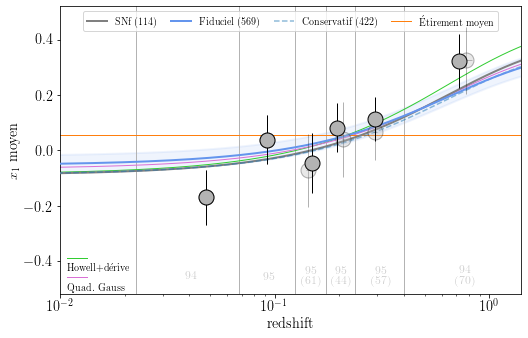

In [73]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)

#############################################################################################

if mean_c.value == 'mean':
    vmap_s = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 6))
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)
else:
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_average[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)


snf, = ax.plot(zlin, age_law_snf(zlin),
               color="0.5", lw=2, ls='-',
               zorder=6)
snflab = 'SNf (114)'

#ax.fill_between(zlin, age_law_snf(zlin) + models_std_snf,
#                age_law_snf(zlin) - models_std_snf,
#                color="0.5", alpha=.1, lw=2)

all, = ax.plot(zlin, age_law_all(zlin),
               color='cornflowerblue', lw=2,
               zorder=8)
alllab = 'Fiduciel (569)'
##        label='Age-drift Model', zorder=8)

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color='cornflowerblue', alpha=.1, lw=2)

#ax.plot(zlin, age_law_all_nsnf(zlin),
#        color="0.5", lw=1, ls='-.',
#        label='All but SNf (455)', zorder=8)

how, = ax.plot(zlin, evolHOWDRIFT.plot_evol(zlin),
               color='limegreen', lw=1)
howlab = 'Howell+dérive'

QG, = ax.plot(zlin, evol4G4M4S.plot_evol(zlin),
              color='orchid', lw=1)
QGlab = 'Quad. Gauss'

ax.set_xlabel(r"redshift", fontsize="x-large")
ax.set_ylabel(r'$x_1$ moyen', fontsize="x-large")

ax.tick_params(labelsize='x-large')

#############################################################################################

if mean_c.value == 'mean':
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
                     xerr=z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                     yerr=x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
                     color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

else:
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean_cons[i], x1_comp_average_cons[i],
                     xerr = z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                     yerr = x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
                     color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

cons, = ax.plot(zlin, age_law_all_cons(zlin),
                color="C0", lw=1.5, ls='--', alpha=.5,
                label='Conservatif (422)', zorder=7)
conslab = 'Conservatif (422)'

#############################################################################################

if mean_c.value == 'mean':
    ax.hline(evol1G1M1S.param['mu'], color='C1',
             lw=1, ls='-')
    hlab = 'Étirement moyen' 
    #ax.hline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

else:
    ax.hline(np.average(df_nc.stretchs,
                        weights=1/(df_nc.stretchs**2 +
                                   minimize('stretchs', 'nc', 'all').values[1]**2)),
             color='C1', lw=1, ls='-')
    hlab = 'Étirement pondéré'

hline = Line2D([0], [0], color='C1', lw=1, ls='-')

#############################################################################################

shift_slices = [[0.007, 0.0085],
                [0.008, 0.0115],
                [0.011, 0.017],
                [0.014, 0.023],
                [0.027, 0.040],
                [0.178, 0.210]]

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2,
                fontsize='large')
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.445,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2,
                fontsize='large')
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2,
                fontsize='large')

#############################################################################################

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

leg_base = ax.legend([snf, all, cons, hline],
                     [snflab, alllab, conslab, hlab],
                     ncol=4, loc='upper center', columnspacing=1.4, fontsize=10)
leg_oth = ax.legend([how, QG],
                    [howlab, QGlab],
                    loc='lower left', fontsize=10,
                    bbox_to_anchor = (-0.005, 0.01, 0.3, 0.3),
                    labelspacing=1,
                    handletextpad=-2,
                    frameon=False)
for txt in leg_oth.get_texts():
    #txt.set_ha("center") # horizontal alignment of text item
    #txt.set_x(-5) # x-position
    txt.set_y(-10) # y-position

ax.add_artist(leg_base)

fig.savefig(f'../../../Images/pdf/stretchevol_all-oth_vs_snf-{mean_c.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/stretchevol_all-oth_vs_snf-{mean_c.value}.png', bbox_inches='tight', dpi=600)

In [28]:
leg_oth.get_()


<a list of 0 Patch objects>

### All simulated

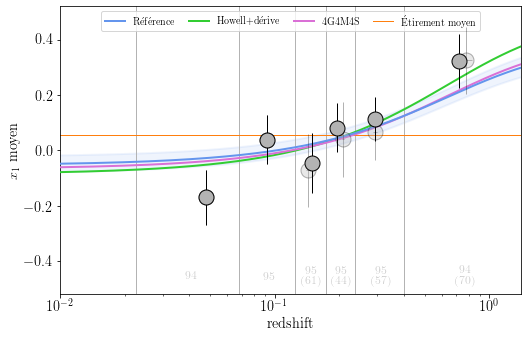

In [21]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)

#############################################################################################

if mean_c.value == 'mean':
    vmap_s = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 6))
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)
else:
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_average[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)

#ax.fill_between(zlin, age_law_snf(zlin) + models_std_snf,
#                age_law_snf(zlin) - models_std_snf,
#                color="0.5", alpha=.1, lw=2)

ax.plot(zlin, evol3G2M2S.plot_evol(zlin),
        color="cornflowerblue", lw=2,
        label='Référence', zorder=8)
##        label='Age-drift Model', zorder=8)

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="cornflowerblue", alpha=.1, lw=2)

# ax.axhline(age_law_allfix(),
#            color='firebrick', lw=2,
#            label='Référence+const', zorder=6)

ax.plot(zlin, age_law_howdrift(zlin),
        color="limegreen", lw=2, ls='-',
        label='Howell+dérive', zorder=6)

ax.plot(zlin, evol4G4M4S.plot_evol(zlin),
        color='orchid', lw=2, ls='-',
        label='4G4M4S', zorder=6)

# ax.axhline(age_law_howfix(),
#            color='r', lw=2,
#            label='Howell+const', zorder=6)

#ax.plot(zlin, age_law_all_nsnf(zlin),
#        color="0.5", lw=1, ls='-.',
#        label='All but SNf (455)', zorder=8)

ax.set_xlabel(r"redshift", fontsize="x-large")
ax.set_ylabel(r'$x_1$ moyen', fontsize="x-large")

ax.tick_params(labelsize='x-large')

#############################################################################################

if mean_c.value == 'mean':
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
                     xerr=z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                     yerr=x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
                     color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

else:
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean_cons[i], x1_comp_average_cons[i],
                     xerr = z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                     yerr = x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
                     color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

# ax.plot(zlin, age_law_all_cons(zlin),
#         color="C0", lw=1.5, ls='--', alpha=.5,
#         label='Conservatif (422)', zorder=7)

#############################################################################################

if mean_c.value == 'mean':
    ax.axhline(evol1G1M1S.param['mu'], color='C1', lw=1, ls='-', label='Étirement moyen')
    # ax.axhline(evolASYM.param['mu'], color='C1', lw=1, ls='--', label='Moyenne asym')

else:
    ax.hline(np.average(df_nc.stretchs,
                        weights=1/(df_nc.stretchs**2 +
                                   minimize('stretchs', 'nc', 'all').values[1]**2)),
             color='C1', lw=1, ls='-', label='Étirement pondéré')

#############################################################################################

shift_slices = [[0.007, 0.0085],
                [0.008, 0.0115],
                [0.011, 0.017],
                [0.014, 0.023],
                [0.027, 0.040],
                [0.178, 0.210]]

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2,
                fontsize='large')
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.445,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2,
                fontsize='large')
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2,
                fontsize='large')

#############################################################################################

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.legend(ncol=4, loc='upper center', columnspacing=1.4, fontsize=10)

fig.savefig(f'../../../Images/pdf/stretchevol_all_vs_rest-{mean_c.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/stretchevol_all_vs_rest-{mean_c.value}.png', bbox_inches='tight', dpi=600)

### Stretchevol all no cons

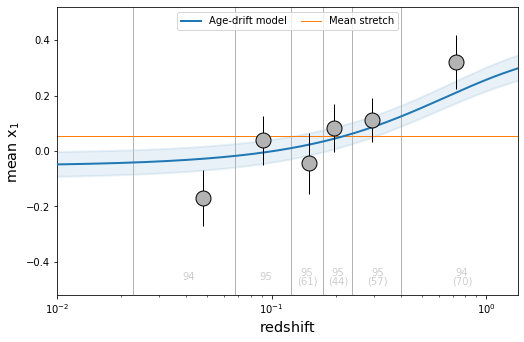

In [44]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)

#############################################################################################

if mean_c.value == 'mean':
    vmap_s = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 6))
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)
else:
    for i, c in zip(range(6), vmap_s):
        ax.errorbar(z_comp_mean[i], x1_comp_average[i],
                    xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
                    yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
                    color=vmap_s[i], **prop, zorder=10, lw=1)

ax.plot(zlin, age_law_all(zlin),
        color="C0", lw=2,
        #label='Reference(569)', zorder=8)
        label='Age-drift model', zorder=8)

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="C0", alpha=.1, lw=2)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

#############################################################################################

# if mean_c.value == 'mean':
#     for i, c in zip(range(6), vmap_s):
#         ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
#                      xerr=z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
#                      yerr=x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
#                      color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)
# 
# else:
#     for i, c in zip(range(6), vmap_s):
#         ax.errorbar(z_comp_mean_cons[i], x1_comp_average_cons[i],
#                      xerr = z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
#                      yerr = x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
#                      color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

#############################################################################################

if mean_c.value == 'mean':
    ax.hline(evol1G1M1S.param['mu'], color='C1', lw=1, ls='-', label='Mean stretch')
    #ax.hline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

else:
    ax.hline(np.average(df_nc.stretchs,
                        weights=1/(df_nc.stretchs**2 +
                                   minimize('stretchs', 'nc', 'all')[1][1]['value']**2)),
             color='C1', lw=1, ls='-', label='Weighted stretch')

#############################################################################################

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.2)
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.2)

#############################################################################################

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.legend(ncol=4, loc='upper center', columnspacing=1.4)

fig.savefig(f'../../../Images/pdf/stretchevol_all_nocons-{mean_c.value}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/stretchevol_all_nocons-{mean_c.value}.png', bbox_inches='tight', dpi=600)

## Stretch and mean evol

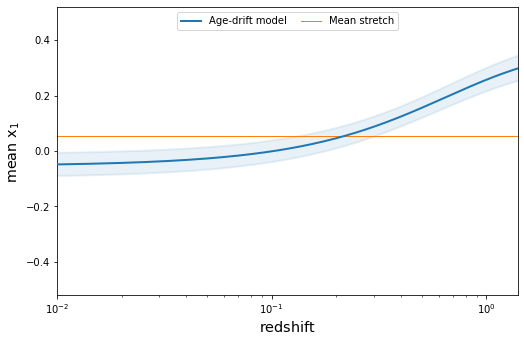

In [94]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

ax.plot(zlin, age_law_all(zlin),
        color="C0", lw=2,
        #label='Reference(569)', zorder=8)
        label='Age-drift model', zorder=8)

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="C0", alpha=.1, lw=2)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

if mean_c.value == 'mean':
    ax.hline(evol1G1M1S.param['mu'], color='C1', lw=1, ls='-', label='Mean stretch')
    #ax.hline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

else:
    ax.hline(np.average(df_nc.stretchs,
                        weights=1/(df_nc.stretchs**2 +
                                   minimize('stretchs', 'nc', 'all')[1][1]['value']**2)),
             color='C1', lw=1, ls='-', label='Weighted stretch')

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.legend(ncol=4, loc='upper center', columnspacing=1.4)

fig.savefig(f'../../../Images/pdf/stretchevol_meanevol.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/stretchevol_meanevol.png', bbox_inches='tight', dpi=600)

## Stretchevol

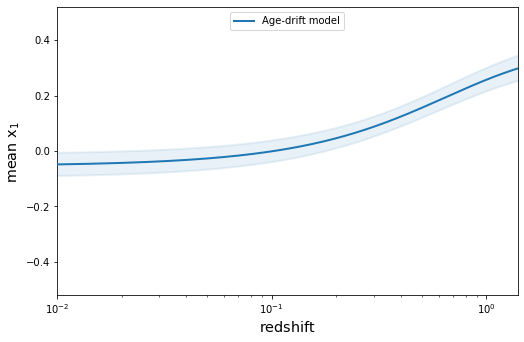

In [93]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

ax.plot(zlin, age_law_all(zlin),
        color="C0", lw=2,
        #label='Reference(569)', zorder=8)
        label='Age-drift model', zorder=8)

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="C0", alpha=.1, lw=2)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.legend(ncol=4, loc='upper center', columnspacing=1.4)

fig.savefig(f'../../../Images/pdf/stretchevol.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/stretchevol.png', bbox_inches='tight', dpi=600)